In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from skimage import io
from monolayer_tracking.segmented_comprehension import Image
from scipy import ndimage
import cellpose.utils as cp_utils
from pathlib import Path

# Segmentation

In [2]:
def get_stitched_boundary(membrane, radius=2):
    from scipy.signal import convolve2d

    boundary=convolve2d(membrane==0, np.ones((2*radius+1,2*radius+1)), mode='same')!=0
    boundary[0]=boundary[-1]=boundary[:,0]=boundary[:,-1]=True

    return boundary

def remove_edge_masks(membrane, masks, radius=2):
    boundary=get_stitched_boundary(membrane, radius)
    # remove all masks that touch the edge
    edge_masks=np.unique(masks[boundary])[1:]
    
    new_masks=masks.copy()
    new_masks[np.isin(new_masks, edge_masks)]=0
    new_masks=np.unique(new_masks, return_inverse=True)[1].reshape(masks.shape) # renumber masks to consecutive integers with edge masks removed
    return new_masks

## CellPose GUI seg.npy to my format

In [5]:
# resume
seg_dir=Path(r'E:\my_data\Segmentation\20240622 FUCCI halo\ME\segmented')
for n in tqdm(range(3,10)):
    file_path=Path(seg_dir/r'tile{}_seg.npy'.format(n))
    seg=np.load(file_path, allow_pickle=True).item()
    img_path=str(file_path.parents[1]).replace('Segmentation','Data')+'/'+file_path.name.replace('seg.npy', 'RGB.tif')
    img=io.imread(img_path)

    masks=remove_edge_masks(img[..., 2], seg['masks'], radius=2)
    outlines_list=cp_utils.outlines_list(masks)
    outlines=cp_utils.masks_to_outlines(masks)

    export={'img':img, 'masks':masks, 'outlines':outlines, 'outlines_list':outlines_list}
    np.save(file_path, export)

  0%|          | 0/7 [00:00<?, ?it/s]

Multiprocessing is disabled for Windows
Multiprocessing is disabled for Windows
Multiprocessing is disabled for Windows
Multiprocessing is disabled for Windows
Multiprocessing is disabled for Windows
Multiprocessing is disabled for Windows
Multiprocessing is disabled for Windows


In [4]:
n

3

# Read heights out of MGX

In [1]:
def read_height_tif(file_path, z_scale=1):
    height_img=io.imread(file_path)
    top_surface=np.argmin(height_img, axis=0).astype(float) # first zero in the height image at each pixel is the top surface
    top_surface[top_surface==0]=np.nan
    top_surface*=z_scale
    return top_surface

In [5]:
class HeightMap(Image):
    def __init__(self, seg_path, mesh_path=None, scale=0.16125, z_scale=0.3225, **kwargs):
        super().__init__(seg_path, scale=scale, **kwargs)
        if mesh_path is None:
            mesh_path=seg_path.replace('segmented','mgx').replace('seg.npy', 'binarized.tif')
        self.mesh=read_height_tif(mesh_path, z_scale=z_scale)
    
    def get_heights(self):
        from scipy.interpolate import RegularGridInterpolator
        x=np.linspace(0,1, self.mesh.shape[1])
        y=np.linspace(0,1, self.mesh.shape[0])
        self.interp=RegularGridInterpolator((y,x), self.mesh)
        x_values=np.linspace(0,1,self.masks.shape[1])
        y_values=np.flip(np.linspace(0,1,self.masks.shape[0]))
        interp_x, interp_y=np.meshgrid(x_values, y_values)
        self.z=self.interp(np.stack([interp_y, interp_x], axis=-1))
        self.x, self.y=np.meshgrid(np.arange(self.masks.shape[1])*self.scale, np.arange(self.masks.shape[0])*self.scale)
        return self.z
    
    def get_volumes(self):
        self.heights=self.get_heights()
        self.volumes=ndimage.sum(self.z, labels=self.masks, index=range(1,self.masks.max()+1))*self.scale**2
        self.mean_heights=ndimage.mean(self.z, labels=self.masks, index=range(1,self.masks.max()+1))
        self.set_cell_attr('volume', self.volumes)
        self.set_cell_attr('height', self.mean_heights)

        return self.volumes

In [12]:
root_dir=r'E:\my_data\Segmentation\20240622 FUCCI halo\ME'
files=[f'tile{n}' for n in range(1,10)]

dataset=[HeightMap(f'{root_dir}/segmented/{file}_seg.npy', scale=0.16125, load_img=True) for file in tqdm(files)]

  0%|          | 0/9 [00:00<?, ?it/s]

In [18]:
root_dir=r'E:\my_data\Segmentation\20240622 FUCCI halo'
files=[f'tile{n}' for n in range(1,10)]

SC=[HeightMap(f'{root_dir}/SC/segmented/{file}_seg.npy', scale=0.16125, load_img=True) for file in tqdm(files)]

  0%|          | 0/9 [00:00<?, ?it/s]

In [20]:
for data in tqdm(SC):
    data.get_volumes()

  0%|          | 0/9 [00:00<?, ?it/s]

1251.955777175032 2435.924067847105


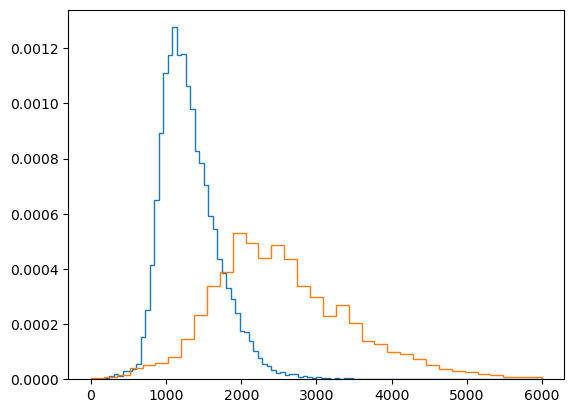

In [24]:
SC_volumes=np.concatenate([data.volumes for data in SC])
SC_volumes=SC_volumes[~np.isnan(SC_volumes)]

plt.hist(volumes, range=(0,6000), bins=100, histtype='step', density=True)
plt.hist(SC_volumes, range=(0,6000), bins=35, histtype='step', density=True)

print(np.median(volumes), np.median(SC_volumes))

In [122]:
tif_tile=HeightMap(r'Y:\Segmentation\20240520 FUCCI halo ME 40x\tile1\tile1_seg.npy', scale=0.16125, load_img=True)
tif_tile.get_volumes()

array([1684.1391167 , 1954.03067676, 1414.86745342, ..., 1109.8390689 ,
        735.77708544,           nan])

In [ ]:
root_dir='Z:/Andy/segmentation/20240520 FUCCI halo ME 40x/'
files=['tile1','tile2']

dataset=[HeightMap(f'{root_dir}{file}/{file}_seg.npy', scale=0.16125, load_img=True) for file in tqdm(files)]

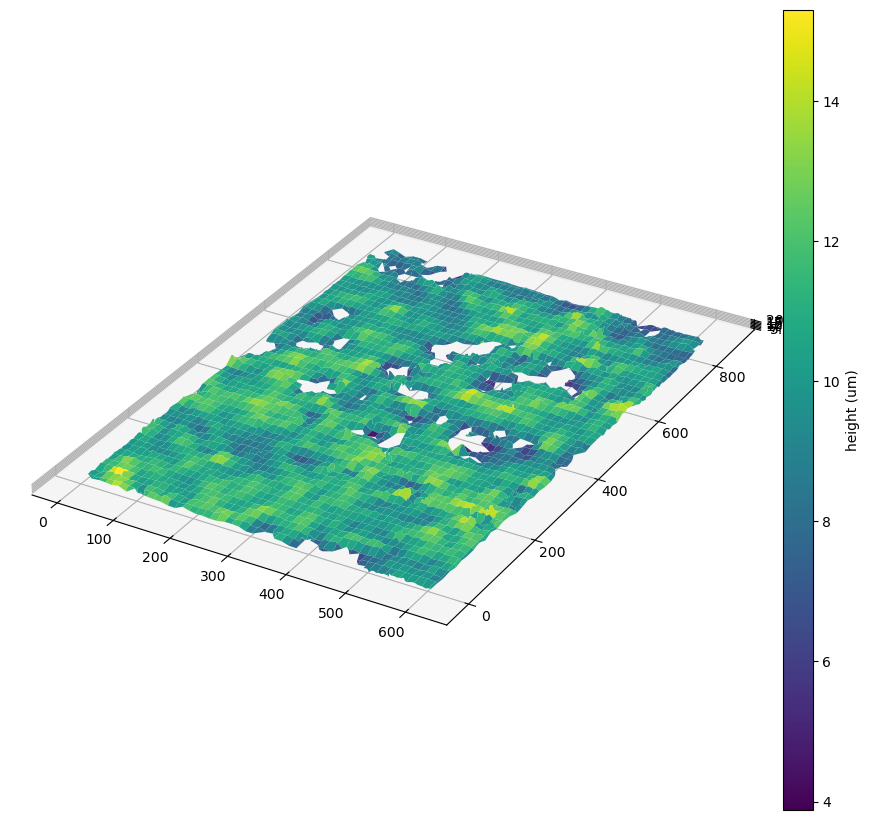

In [123]:
fig, ax=plt.subplots(figsize=(10,10), subplot_kw={'projection': '3d'})
z=tif_tile.z
#z[np.isnan(z)]=0
cb=ax.plot_surface(tif_tile.x, tif_tile.y, tif_tile.z, cmap='viridis')

cax=fig.add_axes([0.9, 0.1, 0.03, 0.8])
plt.colorbar(cb, cax=cax, label='height (um)')

ax.set_aspect('equal')
#ax.axis('off')
#plt.savefig('plots/adhered_volumes/20240520_tile1_height_map.jpg', dpi=300, bbox_inches='tight')

In [413]:
root_dir='Z:/Andy/segmentation/20240520 FUCCI halo ME 40x/'
files=['tile1','tile2']

dataset=[HeightMap(f'{root_dir}{file}/{file}_seg.npy', scale=0.16125, load_img=True) for file in tqdm(files)]

  0%|          | 0/2 [00:00<?, ?it/s]

In [370]:
#tile1=HeightMap(r'Z:\Andy\segmentation\20240520 FUCCI halo ME 40x\tile1\tile1_seg.npy')
tile2=HeightMap(r'Z:\Andy\segmentation\20240520 FUCCI halo ME 40x\tile2\tile2_seg.npy')

# measure volumes

In [414]:
[tile.get_volumes() for tile in tqdm(dataset)]

  0%|          | 0/2 [00:00<?, ?it/s]

[array([1679.44165851, 1958.89701708, 1416.3767858 , ..., 1098.13794971,
         736.12545876,           nan]),
 array([1644.0991158 , 1132.00040505, 1271.92001282, ..., 1012.65215039,
        1199.99714654,   90.28635122])]

In [372]:
import pandas as pd
vol_0407_SC=pd.read_pickle(r'F:\my_data\Segmentation\20240407 FUCCI suspension\volumes\SC.pkl')
vol_0412_ME=pd.read_pickle(r'F:\my_data\Segmentation\20240412 FUCCI_halo_40x suspension ME\volumes\ME.pkl')

Text(0.5, 0, 'volume (um)')

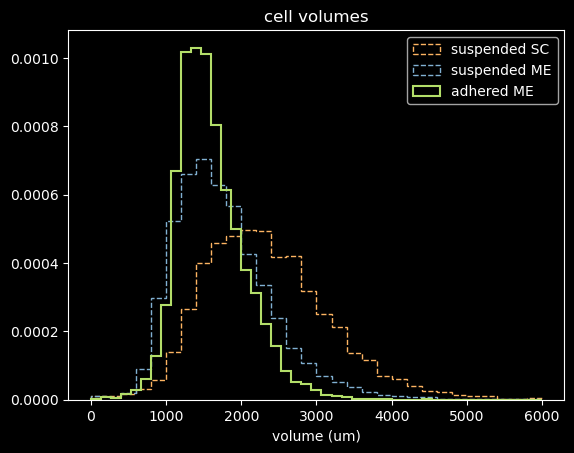

In [416]:
volumes=np.concatenate([tile.volumes for tile in dataset])

plt.hist(np.concatenate(vol_0407_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='suspended SC', color='C5')
plt.hist(np.concatenate(vol_0412_ME[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='suspended ME', color='C4')
plt.hist(volumes, bins=45, range=(0,6000), histtype='step', label='adhered ME', density=True, linewidth=1.5, color='C6')

plt.title('cell volumes')

plt.legend()
plt.xlabel('volume (um)')
#plt.savefig('plots/adhered_volumes/20240520_ME_hist.jpg', dpi=300, bbox_inches='tight')

In [37]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase

  0%|          | 0/4 [00:00<?, ?it/s]

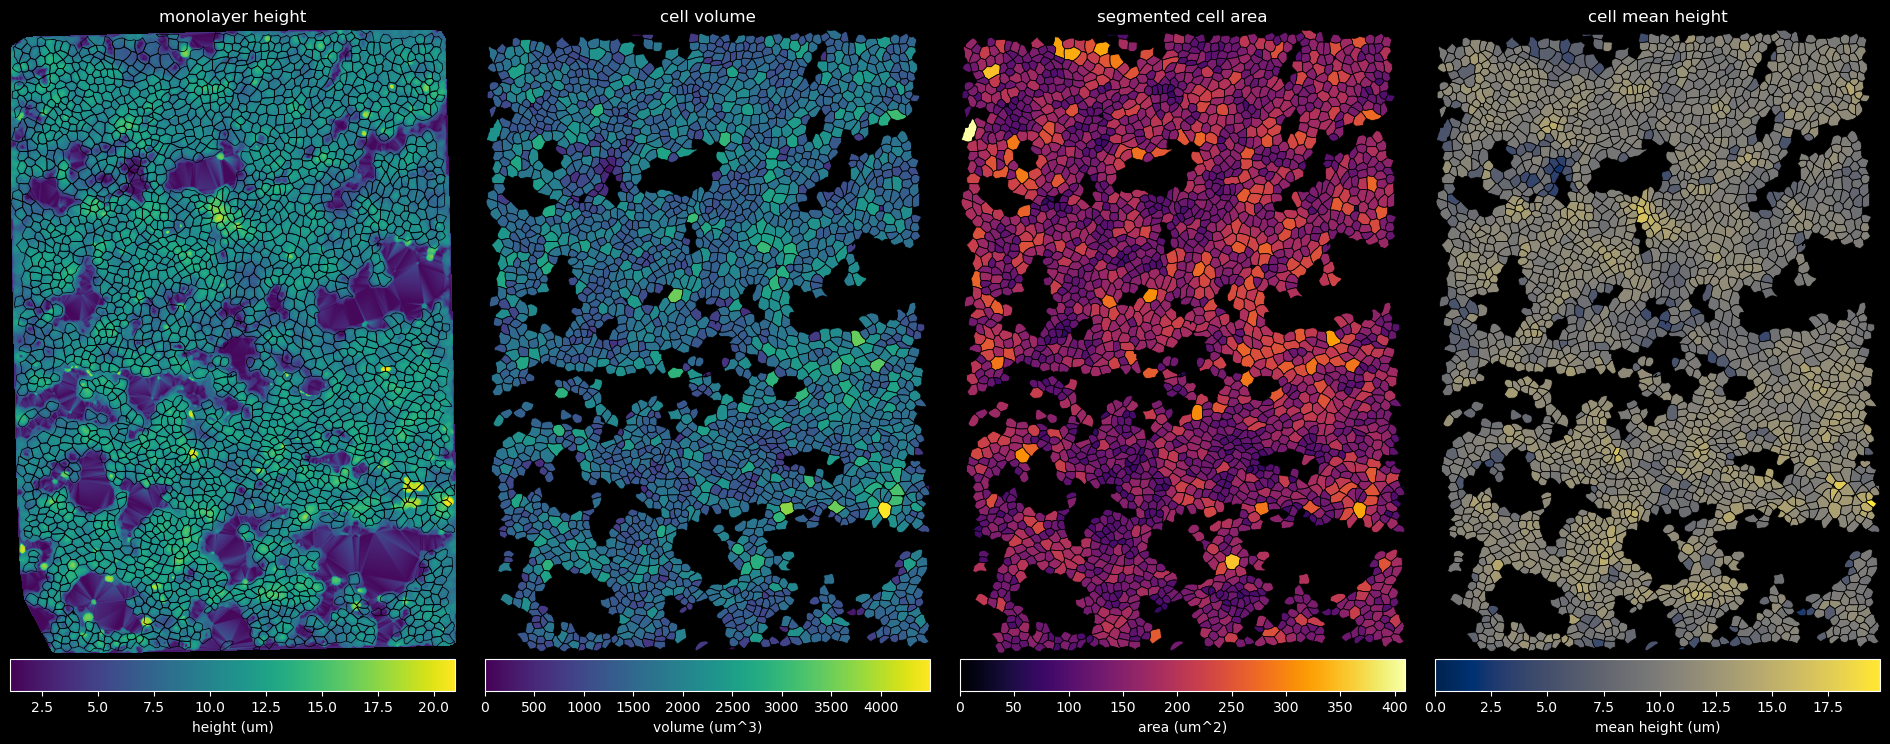

In [374]:
# volume measurement demo
# TODO: use patchcollections
frame=dataset[0]

plt.style.use('dark_background')
figsize=5

fig, (heightAx, volAx, areaAx, meanHeightAx)=plt.subplots(1,4, figsize=(3.8*figsize,figsize*np.divide(*frame.masks.shape)), sharex=True, sharey=True)


pbar=tqdm(total=4)
#---------heights---------
heightMap=heightAx.imshow(z, cmap='viridis')
for cell in frame.cells:
    heightAx.plot(cell.outline[:,0], cell.outline[:,1], c='k', linewidth=0.5)
pbar.update(1)

#---------volumes---------
#volAx.imshow(np.ones_like(frame.masks)*np.nan)
for cell in frame.cells:
    volAx.fill(*cell.outline.T, color=plt.cm.viridis(cell.volume/np.nanmax(frame.volumes)), edgecolor='k', linewidth=0.5)

volMap=cm.ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=np.nanmax(frame.volumes)), cmap='viridis')
volMap.set_array([])
pbar.update(1)

#---------areas---------
areas=frame.cell_areas(scaled=True)
for cell, area in zip(frame.cells, areas):
    areaAx.fill(*cell.outline.T, color=plt.cm.inferno(area/areas.max()), edgecolor='k', linewidth=0.5)
areaMap=cm.ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=areas.max()), cmap='inferno')
areaMap.set_array([])
pbar.update(1)

#---------cell heights---------
for cell in frame.cells:
    meanHeightAx.fill(*cell.outline.T, color=plt.cm.cividis(cell.height/np.nanmax(frame.mean_heights)), edgecolor='k', linewidth=0.5)
meanHeightMap=cm.ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=np.nanmax(frame.mean_heights)), cmap='cividis')
meanHeightMap.set_array([])
pbar.update(1)

# remove axes
for ax in (heightAx, areaAx, meanHeightAx, volAx):
    ax.axis('off')
    ax.set_aspect('equal')
fig.subplots_adjust(bottom=0, top=1, left=0, right=1)

heightAx.set_title('monolayer height')
areaAx.set_title('segmented cell area')
meanHeightAx.set_title('cell mean height')
volAx.set_title('cell volume')

def subplot_colorbar(ax, mappable, label=None, cmap='viridis', location='right', pad=0.05):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider=make_axes_locatable(ax)
    size=f'{100*pad}%'
    if location=='right' or location=='left':
        orientation='vertical'
    elif location=='top' or location=='bottom':
        orientation='horizontal'
    else:
        raise ValueError('location must be right, left, top, or bottom')
    
    cax=divider.append_axes(location, size=size, pad=pad)
    cbar=fig.colorbar(mappable, cax=cax, orientation=orientation, cmap=cmap, label=label)
    return cbar

# colorbars
subplot_colorbar(heightAx, heightMap, cmap='viridis', label='height (um)', location='bottom')
subplot_colorbar(areaAx, areaMap, cmap='inferno', label='area (um^2)', location='bottom')
subplot_colorbar(meanHeightAx, meanHeightMap, cmap='cividis', label='mean height (um)', location='bottom')
subplot_colorbar(volAx, volMap, cmap='viridis', label='volume (um^3)', location='bottom')

fig.tight_layout()
#plt.savefig('plots/adhered_volumes/20240520_tile1.jpg', dpi=300, bbox_inches='tight')

pbar.close()

In [434]:
volumes=np.concatenate([tile.volumes for tile in dataset])
areas=np.concatenate([tile.cell_areas(scaled=True) for tile in dataset])
heights=np.concatenate([tile.mean_heights for tile in dataset])

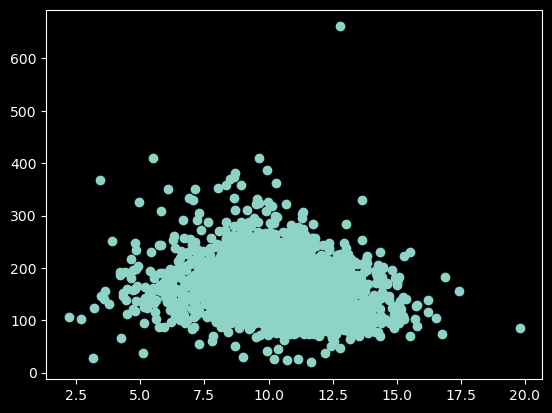

In [441]:
plt.scatter(heights, areas)

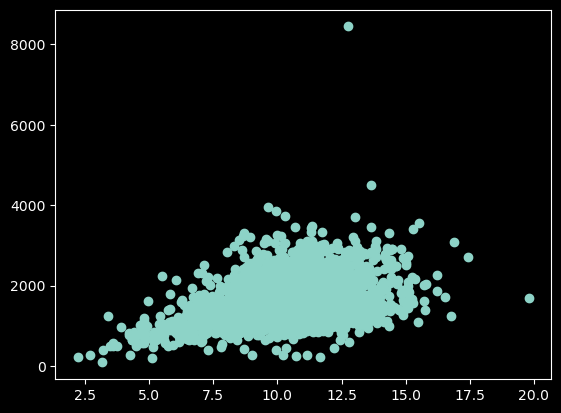

In [442]:
plt.scatter(heights, volumes)

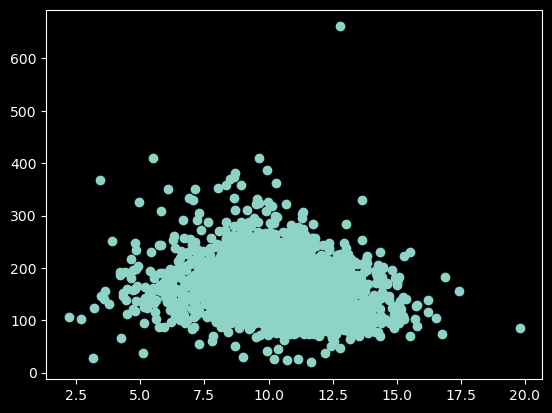

In [443]:
plt.scatter(heights, areas)

(array([0.000e+00, 2.000e+00, 8.000e+00, 3.700e+01, 7.700e+01, 2.190e+02,
        8.100e+02, 1.894e+03, 1.668e+03, 5.180e+02, 9.800e+01, 2.400e+01,
        4.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000., 2200., 2400., 2600., 2800., 3000., 3200., 3400.,
        3600., 3800., 4000., 4200., 4400., 4600., 4800., 5000., 5200.,
        5400., 5600., 5800., 6000.]),
 [<matplotlib.patches.Polygon at 0x21de3590c90>])

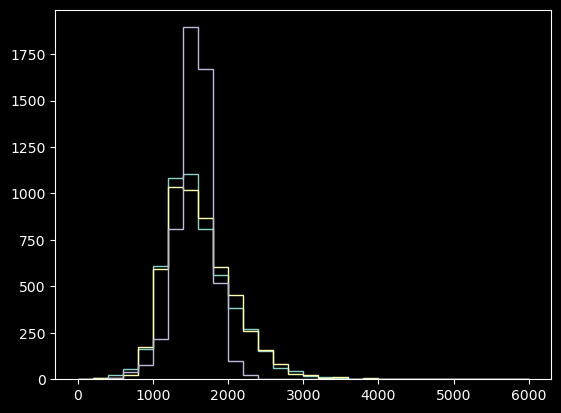

In [440]:
plt.hist(volumes, bins=30, range=(0,6000), histtype='step')
plt.hist(areas*np.nanmedian(heights), bins=30, range=(0,6000), histtype='step')
plt.hist(heights*np.nanmedian(areas), bins=30, range=(0,6000), histtype='step')

(-30.943875000000006,
 649.8213750000001,
 -43.4488125,
 912.4250625000001,
 1.0487163939292152,
 20.961200714111328)

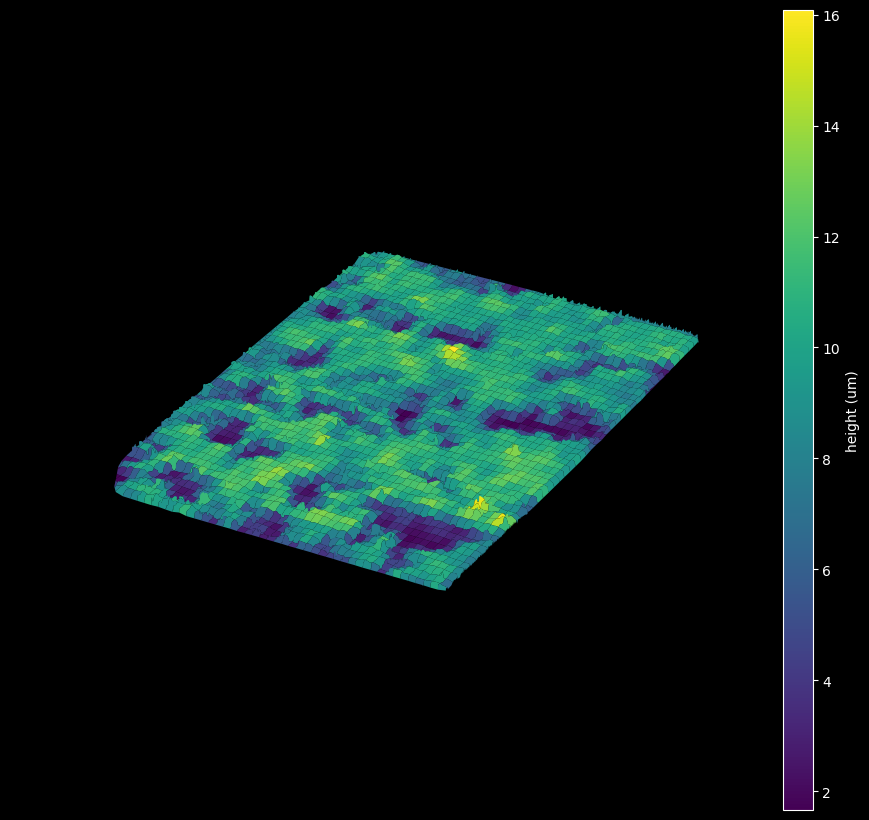

In [375]:
fig, ax=plt.subplots(figsize=(10,10), subplot_kw={'projection': '3d'})
cb=ax.plot_surface(frame.x, frame.y, frame.z, cmap='viridis')

cax=fig.add_axes([0.9, 0.1, 0.03, 0.8])
plt.colorbar(cb, cax=cax, label='height (um)')

ax.set_aspect('equal')
ax.axis('off')
#plt.savefig('plots/adhered_volumes/20240520_tile1_height_map.jpg', dpi=300, bbox_inches='tight')

# FUCCI measurement

In [417]:
from monolayer_tracking import preprocessing

for tile in tqdm(dataset):
    tile.FUCCI=np.array([tile.img[...,0], tile.img[...,1]])
    tile.FUCCI[0]=ndimage.gaussian_filter(tile.FUCCI[0], sigma=5)
    tile.FUCCI[1]=ndimage.gaussian_filter(tile.FUCCI[1], sigma=5)

    tile.FUCCI=preprocessing.normalize(tile.FUCCI)
    tile.measure_FUCCI()

In [380]:
from monolayer_tracking.plot_tools import FUCCI_overlay

Text(0.5, 1.0, '20240520 tile1 FUCCI')

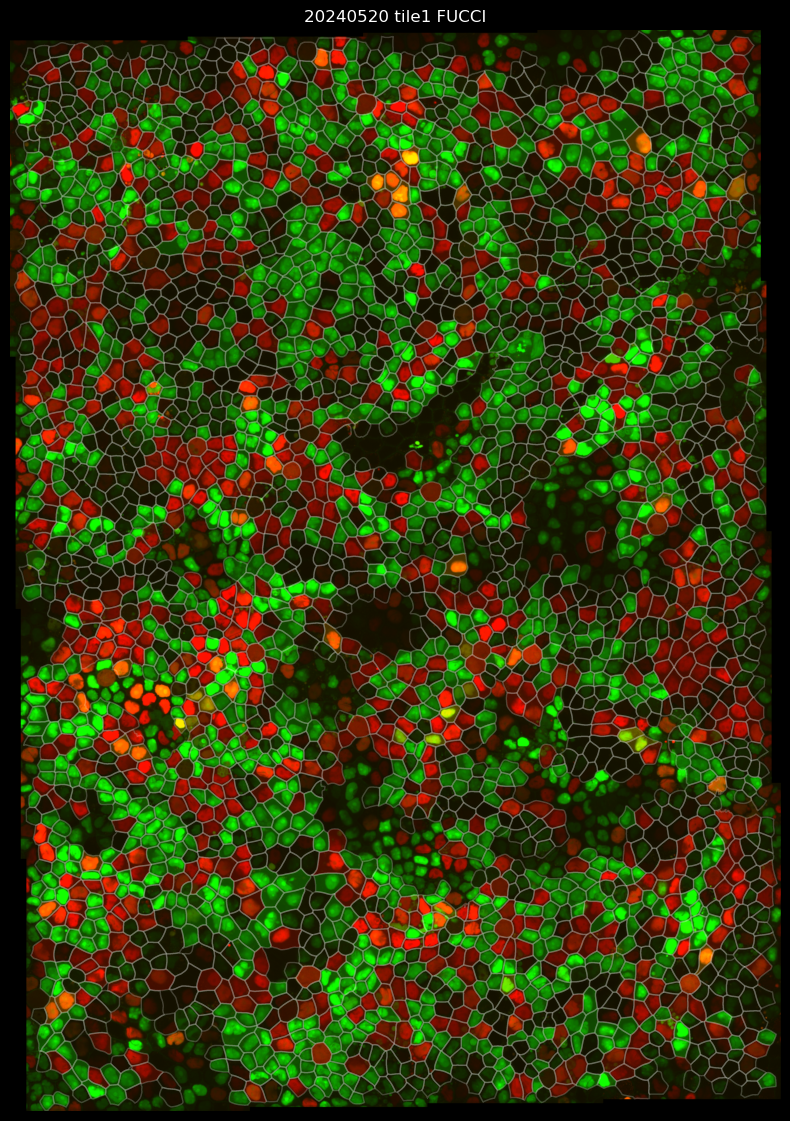

In [418]:
figsize=10
plt.figure(figsize=(figsize,figsize*np.divide(*tile2.masks.shape)))
FUCCI_overlay(dataset[0], show_denoised=False)

plt.title('20240520 tile1 FUCCI')
#plt.savefig('plots/adhered_volumes/20240520_tile1_FUCCI.jpg', dpi=300, bbox_inches='tight')

In [423]:
volumes=np.concatenate([tile.volumes for tile in dataset])
cell_cycles=np.concatenate([tile.get_cell_attr('cycle_stage') for tile in dataset])

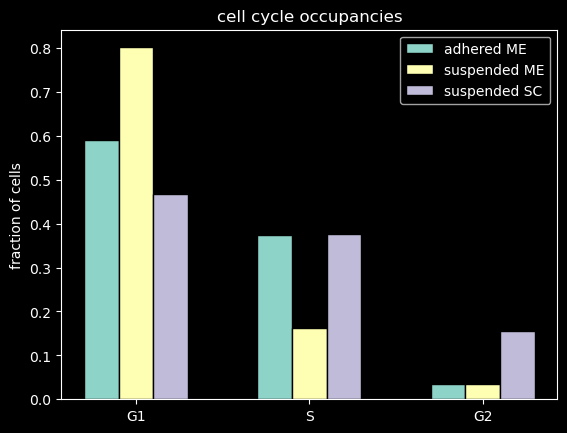

In [422]:
# bar chart of cell cycle occupancies
adhered_occupancies=np.unique(cell_cycles, return_counts=True)[1][1:]
suspended_ME_occupancies=np.array([len(v) for v in vol_0412_ME[1:]])
suspended_SC_occupancies=np.array([len(v) for v in vol_0407_SC[1:]])

adhered_occupancies=adhered_occupancies/np.sum(adhered_occupancies)
suspended_ME_occupancies=suspended_ME_occupancies/np.sum(suspended_ME_occupancies)
suspended_SC_occupancies=suspended_SC_occupancies/np.sum(suspended_SC_occupancies)

plt.bar(np.arange(3)-0.2, adhered_occupancies, width=0.2, label='adhered ME', edgecolor='k', color='C0')
plt.bar(np.arange(3), suspended_ME_occupancies, width=0.2, label='suspended ME', edgecolor='k', color='C1')
plt.bar(np.arange(3)+0.2, suspended_SC_occupancies, width=0.2, label='suspended SC', edgecolor='k', color='C2')

plt.xticks([0,1,2], ['G1', 'S', 'G2'])
plt.ylabel('fraction of cells')

plt.title('cell cycle occupancies')
plt.legend()

#plt.savefig('plots/adhered_volumes/20240520_tile1_cycle_occupancies.jpg', dpi=300, bbox_inches='tight')

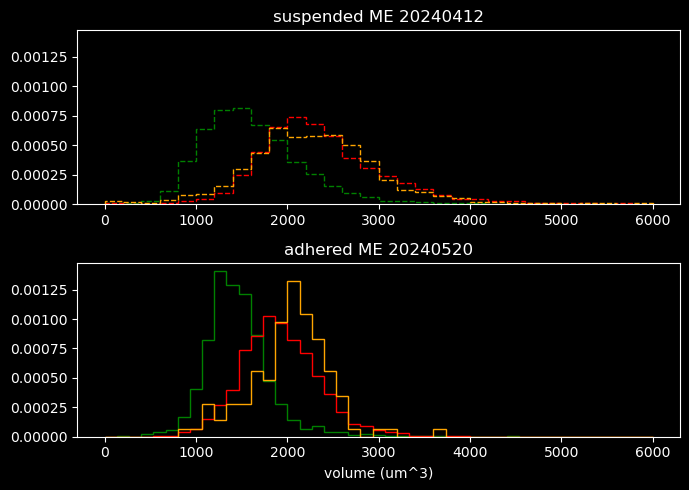

In [444]:
fig, axes=plt.subplots(2,1, figsize=(7,5), sharey=True)
axes[0].hist(vol_0412_ME[1], bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', color='green')
axes[0].hist(vol_0412_ME[2], bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', color='r')
axes[0].hist(vol_0412_ME[3], bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', color='orange')
axes[0].set_title('suspended ME 20240412')

axes[1].hist(volumes[cell_cycles==1], range=(0,6000), bins=45, histtype='step', color='green', density=True)
axes[1].hist(volumes[cell_cycles==2], range=(0,6000), bins=45, histtype='step', color='r', density=True)
axes[1].hist(volumes[cell_cycles==3], range=(0,6000), bins=45, histtype='step', color='orange', density=True)
axes[1].set_title('adhered ME 20240520')

plt.xlabel('volume (um^3)')
fig.tight_layout()

#plt.savefig('plots/adhered_volumes/20240520_tile1_cycle_volumes.jpg', dpi=300, bbox_inches='tight')

In [445]:
adhered_volumes=[volumes[cell_cycles==i] for i in range(4)]

In [450]:
pd.to_pickle(adhered_volumes, r'Z:\Andy\segmentation\20240520 FUCCI halo ME 40x\volumes/ME.pkl')

# Deprecated: Read mesh.txt out of MGX

In [ ]:
def read_mesh(file_path):
    with open(file_path, 'r') as w:
        num_rows=int(w.readline())
    mesh=pd.read_csv(file_path, skiprows=1, delimiter=' ', header=None, index_col=0, nrows=num_rows)
    mesh.index.name=None
    mesh.columns=['x','y','z','?']
    
    return mesh

In [ ]:
# get mesh limits
full_mesh=read_mesh(r'Z:\Andy\segmentation\20240520 FUCCI halo ME 40x\tile5\tile5_mesh.txt')

full_mesh[['x','y','z']].min()

x   -309.60000
y   -434.56900
z     -9.83625
dtype: float64

In [ ]:
class HeightMapMesh(Image):
    def __init__(self, seg_path, mesh_path=None, scale=0.16125, **kwargs):
        super().__init__(seg_path, scale=scale, **kwargs)
        if mesh_path is None:
            mesh_path=seg_path.replace('seg.npy', 'topsurface.txt')
        self.mesh=read_mesh(mesh_path)
        
    def get_heights(self):
        from scipy.interpolate import LinearNDInterpolator

        self.interp=LinearNDInterpolator(self.mesh[['x','y']], self.mesh['z'])
        x_values=np.arange(self.masks.shape[1])*self.scale
        y_values=np.flip(np.arange(self.masks.shape[0])*self.scale)
        self.x, self.y=np.meshgrid(x_values, y_values)
        self.z=self.interp(self.x, self.y)
        
        return self.z
    
    def get_volumes(self):
        self.heights=self.get_heights()
        self.volumes=ndimage.sum(self.z, labels=self.masks, index=range(1,self.masks.max()+1))*self.scale**2
        self.mean_heights=ndimage.mean(self.z, labels=self.masks, index=range(1,self.masks.max()+1))
        self.set_cell_attr('volume', self.volumes)
        self.set_cell_attr('height', self.mean_heights)

        return self.volumes